<a href="https://colab.research.google.com/github/MartsenkoVS/Wrist_Joint_segmentation_nnU-Net/blob/main/Wrist_joint_segmentation_nnU_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [ ]:
!pip install nnunetv2
!pip install triton

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 1.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 23.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 59.1 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 7.3 MB/s eta 0:00:00
  Created wheel for nnune

In [ ]:
!pip install gdown

In [ ]:
import cv2
import numpy as np
import os
import gdown
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import yaml
from nnunetv2.dataset_conversion.generate_dataset_json import generate_dataset_json

# Подготовка датасета для nnU-Net

In [ ]:
def make_nnunet_paths(local_path=None):
    """
    Определяет среду выполнения и устанавливает базовые пути для nnU-Net.
    Если запускается в локальной среде, необходимо указать local_path.
    """
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        base_path = '/kaggle/working'
    elif 'COLAB_GPU' in os.environ:
        base_path = '/content'
    else:
        base_path = local_path  # Путь для локального выполнения

    # Путь, где будут храниться сырые данные
    os.environ['nnUNet_raw'] = os.path.join(base_path,'nnUNet_raw')
    # Путь, где будут храниться предобработанные данные
    os.environ['nnUNet_preprocessed'] = os.path.join(base_path, 'nnUNet_preprocessed')
    # Путь, где будут храниться результаты обучения
    os.environ['nnUNet_results'] = os.path.join(base_path,'nnUNet_results')

    os.makedirs(os.environ['nnUNet_raw'], exist_ok=True)
    os.makedirs(os.environ['nnUNet_preprocessed'], exist_ok=True)
    os.makedirs(os.environ['nnUNet_results'], exist_ok=True)

    return base_path

# Создаем директории для nnU-Net
base_path = make_nnunet_paths()

In [ ]:
# Загружаем датасет
url = 'https://app.roboflow.com/ds/MbypevDx6A?key=Dosxf28buT'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

dataset_dir = 'dataset_dir'
shutil.unpack_archive(output, dataset_dir)
os.remove(output)

Downloading...
From: https://app.roboflow.com/ds/MbypevDx6A?key=Dosxf28buT
To: /kaggle/working/dataset.zip
100%|██████████| 29.4M/29.4M [00:00<00:00, 110MB/s] 


Ссылка на датасет: https://universe.roboflow.com/martsenko/new-hand-xray-lbbnn/dataset/3  
Датасет был размечен в roboflow и выгружен в формате YOLO V9, для U-Net нужен другой формат (маски с номерами классов должны быть нанесены на изображения). Функции ниже конвертируют формат под nnU-Net.  

In [ ]:
def convert_yolo_to_mask(yolo_file, img_file, output_file, priority_class=11):
    """
    Преобразует аннотации YOLO в маски сегментации, с учетом приоритета определенного класса,
    и сохраняет их в виде изображений.

    :param yolo_file: путь к файлу аннотации YOLO.
    :param img_file: путь к соответствующему изображению.
    :param output_file: путь для сохранения сгенерированной маски.
    :param priority_class: класс, который должен быть нанесен последним (по умолчанию 11).
    """
    image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    height, width = image.shape[:2]

    # Инициализируем словарь для хранения масок каждого класса
    masks = {}

    with open(yolo_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0]) + 1  # сдвигаем все классы на 1, чтобы освободить 0 для фона
            points = np.array([float(x) for x in parts[1:]], dtype=np.float32).reshape(-1, 2)
            points[:, 0] *= width
            points[:, 1] *= height
            points = points.astype(np.int32)

            # Создаем маску для текущего класса
            if class_id not in masks:
                masks[class_id] = np.zeros((height, width), dtype=np.uint8)
            cv2.fillPoly(masks[class_id], [points], class_id)  # Наносим классовый идентификатор на маску

    # Объединяем маски, начиная с самых низких приоритетов
    final_mask = np.zeros((height, width), dtype=np.uint8)
    for class_id in sorted(masks):
        if class_id != priority_class:
            final_mask[masks[class_id] > 0] = class_id  # Используем маску текущего класса для обновления финальной маски

    # Накладываем маску приоритетного класса последней
    if priority_class in masks:
        final_mask[masks[priority_class] > 0] = priority_class

    cv2.imwrite(output_file, final_mask)

def create_labels_dict(yaml_file_path: str) -> dict:
    """
    Создает словарь labels из файла YAML, сдвигая все классы на +1, чтобы 0 был фоном.

    :param yaml_file_path: Путь к файлу YAML.
    :return: Словарь с метками, где ключи - это названия классов, а значения - их индексы.
    """
    # Загрузка данных из YAML файла
    with open(yaml_file_path, 'r') as file:
        data = yaml.safe_load(file)

    # Извлечение списка имен классов
    names = data.get('names', [])

    # Создание словаря labels, сдвигая индексы на +1
    labels = {'background': 0}  # добавляем фон как класс с индексом 0
    labels.update({name: i + 1 for i, name in enumerate(names)})

    return labels

def dataset_preprocessing(base_path, nnUNet_dataset_name):
    nnUNet_raw = os.environ.get('nnUNet_raw')
    nnUNet_dataset_dir = os.path.join(nnUNet_raw, nnUNet_dataset_name)
    train_image_dir = os.path.join(nnUNet_dataset_dir, 'imagesTr')
    train_label_dir = os.path.join(nnUNet_dataset_dir, 'labelsTr')

    # Создание директорий для тренировочных данных
    os.makedirs(train_image_dir, exist_ok=True)
    os.makedirs(train_label_dir, exist_ok=True)

    folders = ['train']
    if os.path.exists(os.path.join(base_path, 'test')):
        folders.append('test')  # Добавляем тестовую папку, если она существует
        test_image_dir = os.path.join(nnUNet_dataset_dir, 'imagesTs')
        os.makedirs(test_image_dir, exist_ok=True)

    for folder_name in folders:
        current_image_dir = os.path.join(base_path, folder_name, 'images')
        current_label_dir = os.path.join(base_path, folder_name, 'labels')
        output_image_dir = train_image_dir if folder_name == 'train' else test_image_dir
        output_label_dir = train_label_dir if folder_name == 'train' else None

        for img in sorted(os.listdir(current_image_dir)):
            img_name = os.path.splitext(img)[0]
            img_extension = os.path.splitext(img)[1].lower()

            yolo_annotation_path = os.path.join(current_label_dir, f'{img_name}.txt')
            original_image_path = os.path.join(current_image_dir, img)
            image_path = os.path.join(output_image_dir, f'{img_name}_0000.png')

            # Конвертация исходного изображения в PNG в градации серого
            image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
            cv2.imwrite(image_path, image)

            # Обрабатываем маски только для тренировочных данных
            if output_label_dir:
                mask_output_path = os.path.join(output_label_dir, f'{img_name}.png')
                convert_yolo_to_mask(yolo_annotation_path, image_path, mask_output_path)

    # считаем количество изображений в тренировочной выборке
    num_train = len(os.listdir(train_image_dir))
    print(f'{num_train} изображений сохранено в тренировочную выборку')

    return nnUNet_dataset_dir, num_train

In [ ]:
# Подготовка датасета для nnU-Net
DATASET_NAME = 'WristJoint'
DATASET_ID = '100'
nnUNet_dataset_name = f'Dataset{DATASET_ID}_{DATASET_NAME}'

nnUNet_dataset_dir, num_train = dataset_preprocessing(dataset_dir, nnUNet_dataset_name)
channel_names = {"0": "X-ray"}
labels = create_labels_dict(os.path.join(dataset_dir, 'data.yaml'))

generate_dataset_json(nnUNet_dataset_dir, channel_names, labels,
                          num_train, '.png', dataset_name=nnUNet_dataset_name)

390 изображений сохранено в тренировочную выборку


# Функции для визуализации

In [ ]:
def colorize_mask(mask, color_map):
    """
    Преобразует маску сегментации из числовых значений классов в цветное изображение.
    Если указан color_map, то маски будут раскрашены в соответствии с цветами указанных классов.
    """
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for class_value, color in color_map.items():
        color_mask[mask == class_value] = color  # Каждому классу присваивается заданный цвет.

    return color_mask

def hex_to_rgb(hex_color):
    """
    Конвертирует HEX цвет в кортеж RGB.

    :param hex_color: Строка с HEX кодом цвета, например '#218d7a'.
    :return: Кортеж, содержащий значения RGB (например, (33, 141, 122)).
    """
    # Удаляем символ '#' и конвертируем строку в целое число с основанием 16
    hex_color = hex_color.lstrip('#')
    # Извлекаем и конвертируем R, G, B компоненты
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def show_images_and_masks(image_dir, mask_dir, num_examples=5, color_map=None):
    """
    Отображает изображения и рядом маски.
    Если указан color_map, то маски будут раскрашены в соответствии с цветами указанных классов.

    :param image_dir: Папка с изображениями.
    :param mask_dir: Папка с масками.
    :param num_examples: Количество примеров для отображения.
    :param color_map: Словарь цветов для каждого класса.
    """
    # Получаем список изображений
    image_files = list(Path(image_dir).glob('*.png'))  # Предполагаем, что формат файлов - png
    mask_files = list(Path(mask_dir).glob('*.png'))

    # Сортируем, чтобы соответствие между изображениями и масками сохранялось
    image_files.sort()
    mask_files.sort()

    # Создаем сетку для отображения изображений
    fig, axs = plt.subplots(num_examples, 2, figsize=(10, num_examples * 4))  # 2 столбца для изображения и маски

    for i in range(num_examples):
        # Загрузка изображения
        img = cv2.imread(str(image_files[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Преобразование в RGB

        # Загрузка маски
        mask = cv2.imread(str(mask_files[i]), cv2.IMREAD_GRAYSCALE)  # Загрузка в градациях серого
        # Раскрашиваем маску
        if color_map:
            mask = colorize_mask(mask, color_map)


        # Показ изображения
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Image')
        axs[i, 0].axis('off')

        # Показ маски
        axs[i, 1].imshow(mask)
        axs[i, 1].set_title('Mask')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def show_images_with_masks(image_dir, mask_dir, num_examples=5, color_map=None, alpha=0.5):
    """
    Отображает изображения с наложенными масками.
    Если указан color_map, то маски будут раскрашены в соответствии с цветами указанных классов.

    :param image_dir: Папка с изображениями.
    :param mask_dir: Папка с масками.
    :param num_examples: Количество примеров для отображения.
    :param color_map: Словарь цветов для каждого класса.
    :param alpha: Прозрачность маски.
    """
    image_files = list(Path(image_dir).glob('*.png'))
    mask_files = list(Path(mask_dir).glob('*.png'))
    image_files.sort()
    mask_files.sort()

    fig, axs = plt.subplots(num_examples, 1, figsize=(30, num_examples * 4))

    for i in range(num_examples):
        # Чтение изображения
        img = cv2.imread(str(image_files[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Чтение маски
        mask = cv2.imread(str(mask_files[i]), cv2.IMREAD_GRAYSCALE)

        # Раскрашиваем маску
        if color_map:
            mask = colorize_mask(mask, color_map)

        # Наложение маски на изображение
        combined = cv2.addWeighted(img, 1 - alpha, mask, alpha, 0)

        # Отображение
        axs[i].imshow(combined)
        axs[i].set_title(f'Image with Mask {i+1}')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Цветовая карта классов
color_map = {
    1: hex_to_rgb("#218d7a"),  # MC1
    2: hex_to_rgb("#deb887"),  # MC2
    3: hex_to_rgb("#00FFCE"),  # MC3
    4: hex_to_rgb("#7797be"),  # MC4
    5: hex_to_rgb("#ff0404"),  # MC5
    6: hex_to_rgb("#4e00ae"),  # radius
    7: hex_to_rgb("#00ff12"),  # ulna
    8: hex_to_rgb("#a39797"),  # capitate
    9: hex_to_rgb("#a22e2e"),  # hamate
    10: hex_to_rgb("#3aeaf6"), # lunate
    11: hex_to_rgb("#bfac01"), # pisiform
    12: hex_to_rgb("#a1729c"), # scaphoid
    13: hex_to_rgb("#cfcfcf"), # trapezium
    14: hex_to_rgb("#e3ee6f"), # trapezoid
    15: hex_to_rgb("#d07ab0"), # triquetrum
}

# Запуск nnU-Net

Команда nnUNetv2_plan_and_preprocess снимает отпечаток с датасета, проводит его анализ, подробку параметров, и составляет план обучения.  
Параметры команды:  
-d указываем DATASET_ID или DATASET_NAME;  
--verify_dataset_integrity для проверки датасета;  
-c конфигурация обучения (2d, 3d_fullres, 3d_lowres, 3d_cascade_fullres), в нашем случае 2d для двумерных данных, если не указать, будет выполнен автоматический подбор лучшей конфигурации для датасета;  
-pl планировщик обучения (M/L/XL): https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md

In [ ]:
# Парметры для nnU-Net
UNET_CONFIGURATION = '2d'
PLAN_SIZE = 'M'

In [ ]:
!nnUNetv2_plan_and_preprocess -d {DATASET_ID} --verify_dataset_integrity -c {UNET_CONFIGURATION} -pl nnUNetPlannerResEnc{PLAN_SIZE}

Fingerprint extraction...
Dataset100_WristJoint
Using <class 'nnunetv2.imageio.natural_image_reader_writer.NaturalImage2DIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.natural_image_reader_writer.NaturalImage2DIO'> as reader/writer
100%|█████████████████████████████████████████| 390/390 [00:26<00:00, 14.60it/s]
Experiment planning...
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 12, 'patch_size': (512, 512), 'median_image_size_in_voxels': array([900., 953.]), 'spacing': array([1., 1.]), 'normalization_schemes': ['ZScoreNormalization'], 'use_mask_for_norm': [False], 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs': {'is_seg': False, 'order': 3, 'order_z': 0, 'force_separate_

По умолчанию nnU-Net запускает обучение по 5 фолдам на 1000 эпох, это очень долго, так как я ограничен в ресурсах, проведу обучение только на 0 фолде на 100 эпох. Для этого нужно сохранить свой файл с разбиением по пути: nnUNet_preprocessed/Dataset100_WristJoint/splits_final.json, оставим только разбиение для 0 фолда.

In [ ]:
# Путь к файлу с разбиениями
splits_final_json = os.path.join(os.environ['nnUNet_preprocessed'], nnUNet_dataset_name, 'splits_final.json')

# Загружаем готовый файл с разбиениями
url = 'https://raw.githubusercontent.com/MartsenkoVS/Wrist_Joint_segmentation_nnU-Net/refs/heads/main/splits_final.json'
gdown.download(url, splits_final_json, quiet=False)

Downloading...
From: https://raw.githubusercontent.com/MartsenkoVS/Wrist_Joint_segmentation_nnU-Net/refs/heads/main/splits_final.json
To: /kaggle/working/nnUNet_preprocessed/Dataset100_WristJoint/splits_final.json
26.3kB [00:00, 25.0MB/s]                   


'/kaggle/working/nnUNet_preprocessed/Dataset100_WristJoint/splits_final.json'

## Обучение модели

Запускаем обучение для нашего датасета c параметрами:  
0 - номер fold, который будем обучать;  
-p план обучения;  
-tr nnUNetTrainer_100epochs - максимальное количество эпох (по умолчанию 1000 эпох);

In [ ]:
!nnUNetv2_train {DATASET_ID} {UNET_CONFIGURATION} 0 -p nnUNetResEncUNet{PLAN_SIZE}Plans -tr nnUNetTrainer_100epochs

Using device: cuda:0
/opt/conda/lib/python3.10/site-packages/nnunetv2/training/nnUNetTrainer/nnUNetTrainer.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler() if self.device.type == 'cuda' else None

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2024-09-23 14:53:52.994842: do_dummy_2d_data_aug: False
2024-09-23 14:53:52.999815: Using splits from existing split file: /kaggle/working/nnUNet_preprocessed/Dataset100_WristJoint/splits_final.json
2024-09-23 14:53:53.000212: The split file contains 1 splits.
2024-09-23 14:53:53.

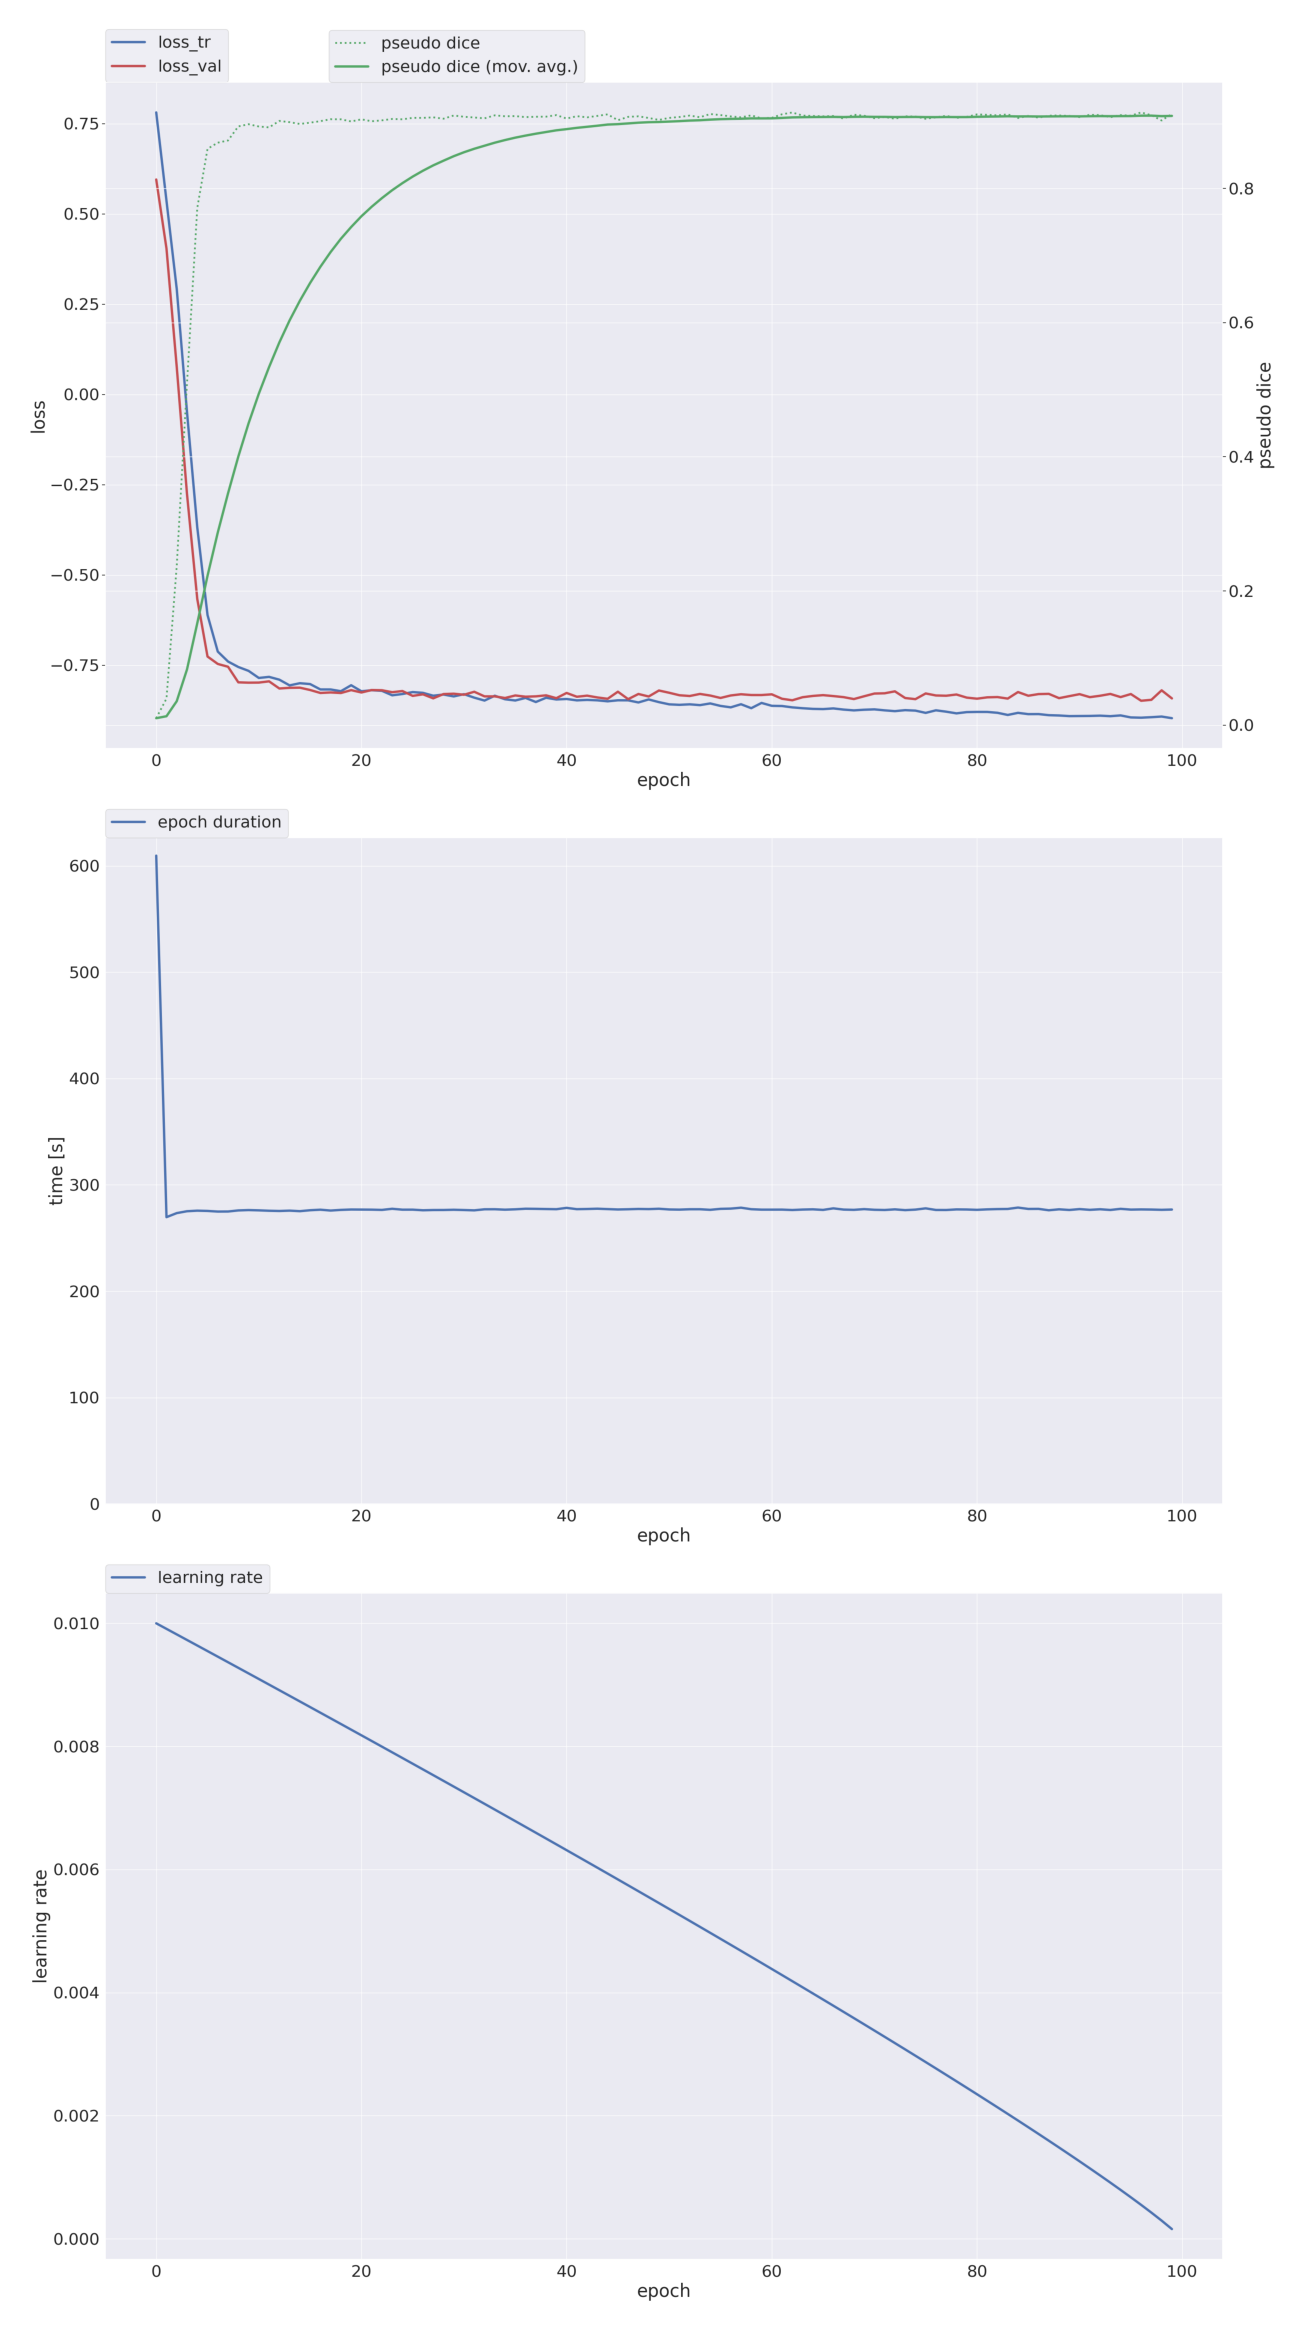

In [ ]:
# Графики обучения
progress_path = '/kaggle/working/nnUNet_results/Dataset100_WristJoint/nnUNetTrainer_100epochs__nnUNetResEncUNetMPlans__2d/fold_0/progress.png'
progress_img = cv2.imread(progress_path)
progress_img = cv2.cvtColor(progress_img, cv2.COLOR_BGR2RGB)  # Преобразование в RGB для корректного отображения в matplotlib

plt.figure(figsize=(30,30))
plt.imshow(progress_img)
plt.axis('off')
plt.show()

## Проверка на тестовых данных

In [ ]:
TEST_FOLDER = '/kaggle/working/nnUNet_raw/Dataset100_WristJoint/imagesTs'
OUTPUT_FOLDER = '/kaggle/working/nnUNet_results/Dataset100_WristJoint/nnUNetTrainer_100epochs__nnUNetResEncUNetMPlans__2d/fold_0/predict'

Запускаем предикт по тестовому набору из датасета c параметрами:  
-i директория с тестовыми изображениями;  
-o директория, куда будут сохраняться маски, предсказанные моделью;  
-d DATASET_ID;  
-f фолды, на которых обучали модели;  
-p план обучения;  
-tr класс Trainer, если запускали не стандартное обучение на 1000 эпох;  
-chk чекпоинт обученных моделей, либо best, либо last по умолчанию.

In [ ]:
!nnUNetv2_predict
-i '/kaggle/working/nnUNet_raw/Dataset100_WristJoint/imagesTs'
-o '/kaggle/working/nnUNet_results/Dataset100_WristJoint/nnUNetTrainer_100epochs__nnUNetResEncUNetMPlans__2d/fold_0/predict'
-d 100 -c 2d
-f 0
-p nnUNetResEncUNetMPlans
-tr nnUNetTrainer_100epochs
-chk checkpoint_best.pth



#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

/opt/conda/lib/python3.10/site-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary 

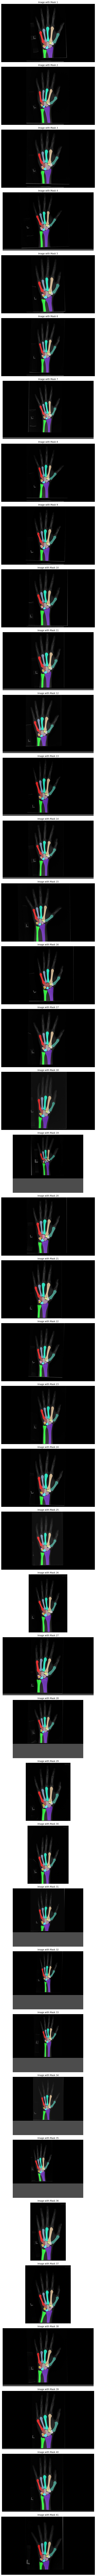

In [ ]:
# Маски, предсказанные моделью накладываем на оригинальное изображение и выводим результаты
num_examples = len(os.listdir(TEST_FOLDER))
show_images_with_masks(TEST_FOLDER, OUTPUT_FOLDER, num_examples=num_examples, color_map=color_map, alpha=0.7)

## Экспорт модели

Команда для экспорта обученных моделей, параметры такие же, как и в predict.

In [ ]:
!nnUNetv2_export_model_to_zip -d 100 -o 'Wrist_Joint_segmentation_nnU-Net.zip' -c 2d -p nnUNetResEncUNetMPlans -tr nnUNetTrainer_100epochs -chk checkpoint_best.pth -f 0

Команда для установки модели для использования

In [ ]:
!nnUNetv2_install_pretrained_model_from_zip 'Wrist_Joint_segmentation_nnU-Net.zip'

# About nnU-Net

https://github.com/MIC-DKFZ/nnUNet

https://www.nature.com/articles/s41592-020-01008-z  
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring
method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.